In [ ]:
!pip install lightfm

In [ ]:
import numpy as np
import pandas as pd
import tqdm
import re

from lightfm import LightFM

In [ ]:
from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import svds
import numpy
import scipy.sparse

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
books = pd.read_csv("/content/gdrive/MyDrive/BX-Books.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
interactions = pd.read_csv("/content/gdrive/MyDrive/BX-Book-Ratings.csv", sep=";", encoding = "ISO-8859-1")

In [ ]:
users = pd.read_csv('/content/gdrive/MyDrive/BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')

In [ ]:
books.columns = ['ISBN', 'BookTitle', 'BookAuthor', 'YearOfPublication', 'Publisher', 'ImageUrlS', 'ImageUrlM', 'ImageUrlL']
users.columns = ['UserID', 'Location', 'Age']
interactions.columns = ['UserID', 'ISBN', 'BookRating']

In [ ]:
interactions.head()

UserID        ISBN  BookRating_x  ...      Country  product_id    vid
0  86583   3404139178  9             ...  germany      10265       3426 
1  132500  3404139178  10            ...  usa          10265       5220 
2  66483   3404139178  10            ...  germany      10265       2608 
3  276866  3404139178  9             ...  germany      10265       10830
4  106534  3404139178  6             ...  switzerland  10265       4205 

[5 rows x 15 columns]

### *Уточнение: пользователь = читатель = user*
### *Выводить будем названия рекомендованных книг и их картинки.*

# Предобработка

In [ ]:
#оставим только одну картинку
books.drop(['ImageUrlS', 'ImageUrlL'],axis=1,inplace=True)

In [ ]:
books.dtypes

ISBN                 object
BookTitle            object
BookAuthor           object
YearOfPublication    object
Publisher            object
ImageUrlM            object
dtype: object

In [ ]:
#посмотрим, как отображается год
books.YearOfPublication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [ ]:
#отображение полного текста в ячейке
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [ ]:
#корректировка данных
books.loc[books.YearOfPublication == 'Gallimard',:]

ISBN  ...                                                     ImageUrlM
220731  2070426769  ...  http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg

[1 rows x 6 columns]

In [ ]:
books.loc[books.ISBN == '078946697X','YearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','YearOfPublication'] = 2000

books.loc[books.ISBN == '078946697X','BookAuthor'] = 'Michael Teitelbaum'
books.loc[books.ISBN == '0789466953','BookAuthor'] = 'James Buckley'

books.loc[books.ISBN == '078946697X','Publisher'] = 'DK Publishing Inc'
books.loc[books.ISBN == '0789466953','Publisher'] = 'DK Publishing Inc'

books.loc[books.ISBN == '078946697X','BookTitle'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.loc[books.ISBN == '0789466953','BookTitle'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'

books.loc[books.ISBN == '2070426769','YearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','BookAuthor'] = 'Jean-Marie Gustave Le ClÃ?ÃÂ©zio'
books.loc[books.ISBN == '2070426769','Publisher'] = 'Gallimard'
books.loc[books.ISBN == '2070426769','BookTitle'] = 'Peuple du ciel, suivi de Les Bergers'

In [ ]:
#переведем в численные значения
books.YearOfPublication=pd.to_numeric(books.YearOfPublication, errors='coerce')

In [ ]:
books.loc[books.YearOfPublication == 2006,:]

ISBN  ...                                                     ImageUrlM
200148  1903436346  ...  http://images.amazon.com/images/P/1903436346.01.MZZZZZZZ.jpg
213487  0743448987  ...  http://images.amazon.com/images/P/0743448987.01.MZZZZZZZ.jpg
235827  0743456874  ...  http://images.amazon.com/images/P/0743456874.01.MZZZZZZZ.jpg

[3 rows x 6 columns]

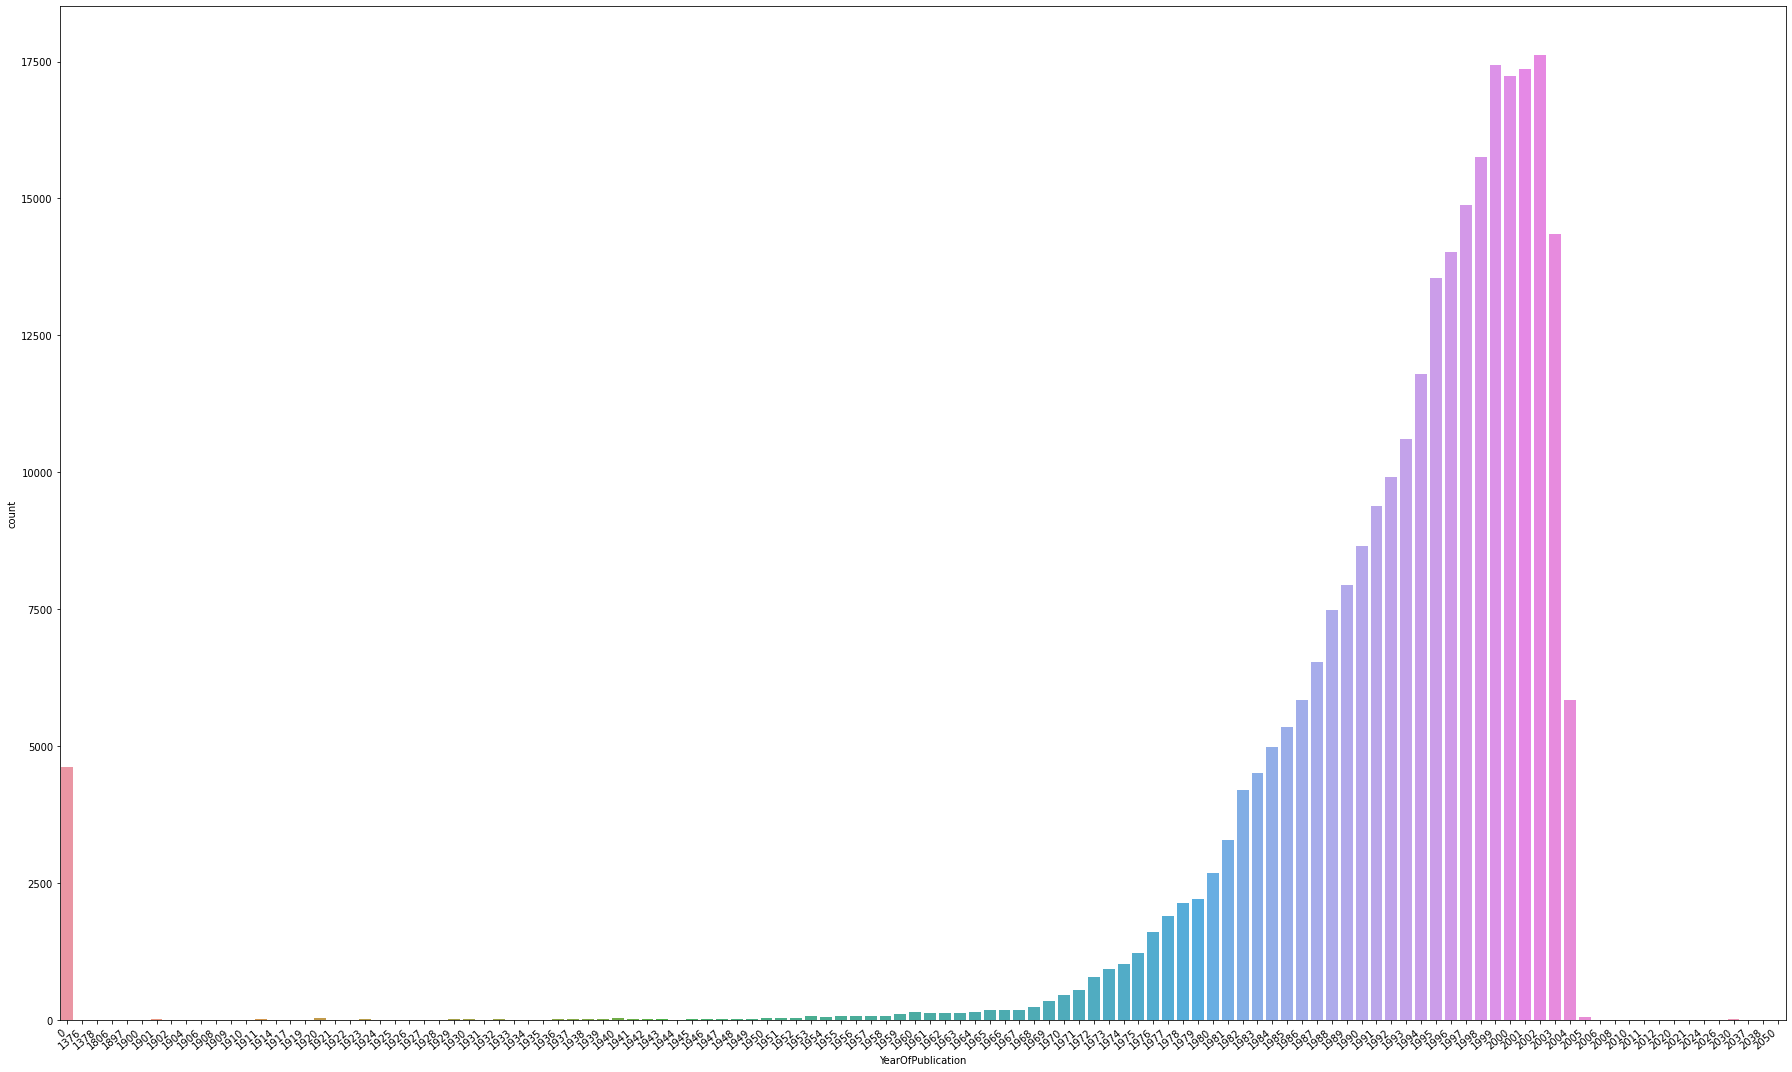

In [ ]:
#посмотрим, есть ли выбросы и некоорректные данные
plt.figure(figsize=(25, 15))
ax = sns.countplot(data=books, x='YearOfPublication')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
#?????????????????????????по графику видно, что данные старые (последний год - 2004)?????????????????????????????
books = books[books.YearOfPublication != 0]
books = books[books.YearOfPublication < 2005]

In [ ]:
interactions = interactions[interactions["BookRating"] != 0]

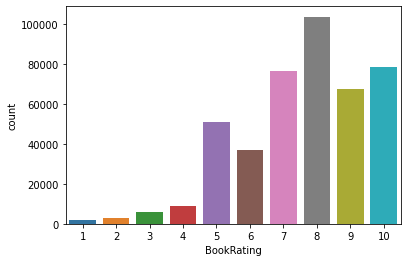

In [ ]:
sns.countplot(data=interactions , x='BookRating')
plt.show()

In [ ]:
#сколько читателей у книги
books_meets = interactions.groupby("ISBN")["UserID"].count().reset_index().rename(columns={"UserID": "user_num"})

In [ ]:
#сколько книг у читателя
user_meets = interactions.groupby("UserID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})

In [ ]:
interactions = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["UserID"])

In [ ]:
interactions = interactions[(interactions["user_num"] > 5) & 
                            (interactions["books_num"] > 5) &
                            (interactions["books_num"] < 200)]

In [ ]:
interactions = interactions.merge(books[["ISBN", "ImageUrlM", "BookTitle", "BookAuthor", "Publisher"]].rename(
    columns={"ImageUrlM": "picture_url"}), on=["ISBN"])

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
interactions = interactions.merge(users[["UserID", 'Age', 'Location']], on=["UserID"])

In [ ]:
#вычислим средний рейтинг для каждой книги
mean_rating = pd.DataFrame(interactions.groupby(['ISBN'])['BookRating'].mean()).sort_values('BookRating', ascending = False)
interactions = interactions.merge(mean_rating, on=["ISBN"]) #BookRating_y - средний рейтинг

In [ ]:
interactions.loc[interactions.Location == 'fürth, ,', 'Country'] = 'germany'
interactions.loc[interactions.Location == 'bourbonnais, ,', 'Country'] = 'france'
interactions.loc[interactions.Location == 'somerset, ,', 'Country'] = 'united kingdom'
interactions.loc[interactions.Location == 'leroy, ,', 'Country'] = 'france'
interactions.loc[interactions.Location == 'toronto, ,', 'Country'] = 'canada'
interactions.loc[interactions.Location == 'ottawa, ,', 'Country'] = 'canada'
interactions.loc[interactions.Location == 'montreal, ,', 'Country'] = 'canada'

In [ ]:
#обычно рейтинги составляются по стране, добавим колонку Country
def country(Location):
  if Location.split(', ')[-1] == ',':
    return 'usa' #стоит заметить, что большинство городов с пропущенно страной относится к США
  else:
    return Location.split(', ')[-1]

interactions.loc[:, 'Country'] = interactions.Location.apply(country)

In [ ]:
interactions[interactions.Country=='russia']

UserID        ISBN  ...  BookRating_y  Country
5546  126531  0345417623  ...  7.857143      russia 

[1 rows x 13 columns]

In [ ]:
#в возрастах также ошибки: оставим диапазон возрастов, которые могли бы оставить оценку
#для пустых значений поставим средний
interactions.loc[(interactions.Age > 90) | (interactions.Age < 7), 'Age'] = np.nan
interactions.Age = interactions.Age.fillna(interactions.Age.mean()).astype(np.int32)

In [ ]:
users["UserID"].unique()

array([     1,      2,      3, ..., 278856, 278857, 278858])

In [ ]:
interactions["product_id"] = le.fit_transform(interactions["ISBN"])
interactions["vid"] = le.fit_transform(interactions["UserID"])

In [ ]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(product_ids, content_dict, measure=None, top_n=5):
    picture_urls = [content_dict[i] for i in product_ids]
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                r = requests.get(i)
                im = Image.open(BytesIO(r.content))

            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                a.title.set_text("measure = {}".format(np.round(measure[cnt], 4)))
                cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.show()

# 1. Персональный топ



In [ ]:
class Top():
    def __init__(self, interactions):
        self.product_id_to_url = {}
        
        for i in interactions[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = interactions
        
    def top_items(self, country, age, rating):
        #для топа учтем страну, рейтинг (который задается пользователем) и возраст (возьмем +-5лет)
        self.interactions = interactions[(interactions['Country'] == country) & (interactions['BookRating_y'] >= rating) & (abs(interactions['Age'] - age) <= 5)]
        items = self.interactions.groupby("product_id")["vid"].count()\
                                .reset_index()\
                                .sort_values("vid", ascending=False)[:10]
        books = items["product_id"].values
        self.book = []
        if items.empty:
          print('no books')                
        else:
          for i in range(len(books)):          
            self.book.append(self.interactions[(self.interactions['product_id'] == books[i])]['BookTitle'].unique())
          k = 1
          for i in range(len(self.book)):
            print(k , ' ' , self.book[i])
            k+=1          
          rec_imaging(items["product_id"].values, self.product_id_to_url, items["vid"].values)

1   ['Artemis Fowl (Artemis Fowl, Book 1)']
2   ['Captain Underpants and the Invasion of the Incredibly Naughty Cafeteria Ladies from Outer Space']
3   ['Welcome to Dead House (Goosebumps, No 1)']
4   ['The Tao of Pooh']
5   ['Sabriel (The Abhorsen Trilogy)']
6   ['Captain Underpants and the Attack of the Talking Toilets: Another Epic Novel (Captain Underpants (Paper))']
7   ['The Adventures of Captain Underpants: An Epic Novel (Captain Underpants)']
8   ["The Midwife's Apprentice (Trophy Newbery)"]
9   ['Holes (Yearling Newbery)']
10   ['A Friend of the Earth']


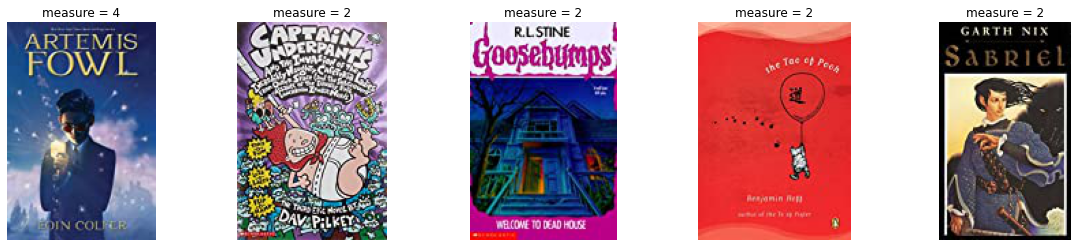

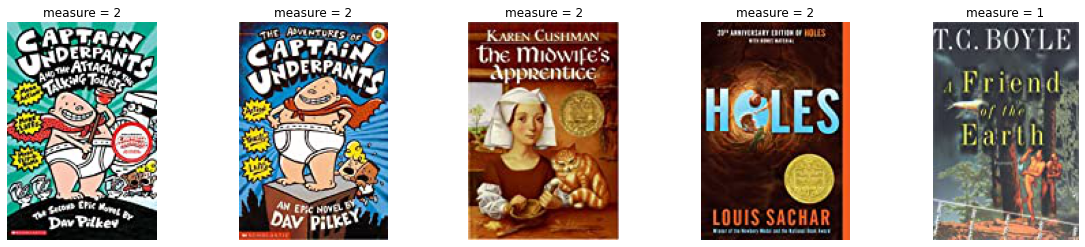

In [ ]:
T = Top(interactions)
T.top_items('canada', 12, 0)

# 2. Рекомендации на основе метода кластеризации похожих пользователей 

In [ ]:
class Rec_for_similar():
    def __init__(self, interactions):
        self.product_id_to_url = {}  
        self.ratings = {}
        self.top_books = []  
        self.top_rat = []    
        self.interactions = interactions
        self.csr_rates = coo_matrix((interactions["BookRating_x"], (interactions["vid"], interactions["product_id"])), 
                    shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))       
        self.sim_matrix = cosine_similarity(self.csr_rates)
   
    def top_rec(self, userID):   
        #по пользователю берем строку в матрице, сортируем в обратном порядке значения схожести и берем индексы
        ranked = np.argsort(self.sim_matrix[userID])[::-1] 
        #по пользователю берем строку в матрице, сортируем в обратном порядке значения схожести и берем сами значения
        values = np.sort(self.sim_matrix[userID])[::-1]
        n = 0        
        #найдем n похожих
        for i in values:
          if i > 0:
            n +=1 

        n_max = 6
        if n <= n_max:
          n = n
        else:
          n = n_max
    
        #берем первых наиболее похожих
        sim_usersID = ranked[1:n+1] 
        #для читателя
        self.interactions1 = self.interactions[self.interactions['vid'] == userID]        
        #выделяем похожих читателей, то есть мы формируем кластер вокруг данного пользователя
        self.interactions = self.interactions[self.interactions['vid'].isin(sim_usersID)]

        #книги, которые читал подльзователь
        user_books = self.interactions1['product_id'].unique()
        #собственно те книги, которые читали похожие пользователи
        books_for_user = self.interactions['product_id'].unique()
        #книги, которые пользователь еще не читал
        self.interactions = self.interactions[~self.interactions['product_id'].isin(self.interactions1['product_id'])]        
        #предскажем оценки для этих книг от user
        for i in self.interactions[['product_id', 'picture_url']].drop_duplicates().values:
          self.product_id_to_url[i[0]] = i[1]
          #по формуле с 25 слайда          
          self.ratings[i[0]] = np.round(1 / len(self.interactions[self.interactions['product_id'] == i[0]]) * sum(self.interactions[self.interactions['product_id'] == i[0]]['BookRating_x']))  
        list_d = list(self.ratings.items())
        list_d.sort(key=lambda i: i[1], reverse = True)   

        top_books = []
        top_rat = []
        for i in range(len(list_d[:10])):
          top_books.append(list_d[:10][i][0])
          top_rat.append(list_d[:10][i][1])

        book = []
        if not top_books:
          print('no books')   
                
        else:
          for i in range(len(top_books)):          
            book.append(self.interactions[(self.interactions['product_id'] == top_books[i])]['BookTitle'].unique())
          k = 1
          print('Топ книг:')
          for i in range(len(book)):
            print(k , ' ' , book[i])
            k+=1  
        rec_imaging(top_books, self.product_id_to_url, top_rat)
    

Топ книг:
1   ['Die SÃ?Â¤ulen der Erde. Roman.']
2   ['Dunkel.']
3   ['Die geliehene Zeit.']
4   ['Ferne Ufer. Der 3. Band der groÃ?Â?en Highland- Saga.']
5   ['Mit dem KÃ?Â¼hlschrank durch Irland.']
6   ['Point of Origin']
7   ['Der Kleine Hobbit']
8   ['Im Angesicht des Feindes.']
9   ['Auf Ehre und Gewissen. Roman.']
10   ['Die Gefahrten I']


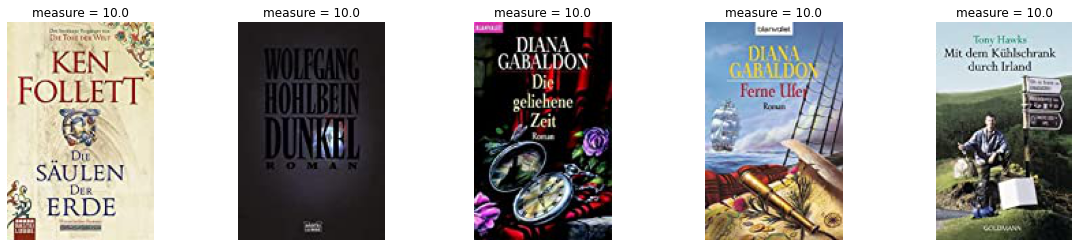

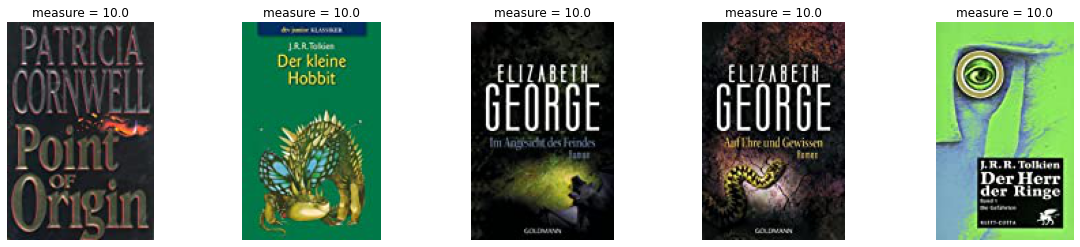

In [ ]:
R = Rec_for_similar(interactions)
R.top_rec(2608)

# 3. Методы, расмотренные на лекции




In [ ]:
#найдем id книг по названию
for i, j in interactions[["product_id", "BookTitle"]].drop_duplicates().values:
    if "Harry Potter" in j:
        print("product_id:", i, "\tBookTitle:", j)

product_id: 10427 	BookTitle: Harry Potter und die Kammer des Schreckens
product_id: 10426 	BookTitle: Harry Potter und der Stein der Weisen
product_id: 10428 	BookTitle: Harry Potter und der Gefangene von Azkaban
product_id: 10429 	BookTitle: Harry Potter Und Der Feuerkelch
product_id: 4168 	BookTitle: Harry Potter and the Order of the Phoenix (Book 5)
product_id: 6948 	BookTitle: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
product_id: 4151 	BookTitle: Harry Potter and the Chamber of Secrets (Book 2)
product_id: 4161 	BookTitle: Harry Potter and the Goblet of Fire (Book 4)
product_id: 6947 	BookTitle: Harry Potter and the Sorcerer's Stone (Book 1)
product_id: 4173 	BookTitle: Harry Potter and the Chamber of Secrets Postcard Book
product_id: 4159 	BookTitle: Harry Potter and the Prisoner of Azkaban (Book 3)
product_id: 4152 	BookTitle: Harry Potter and the Chamber of Secrets (Book 2)
product_id: 4160 	BookTitle: Harry Potter and the Prisoner of Azkaban (Book 3)
pro

## *Совстречаемость*





In [ ]:
class Recomendations():
    def __init__(self, interactions):
        self.product_id_to_url = {}
        for i in interactions[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = interactions
        self.csr_rates = coo_matrix((interactions["BookRating_x"], (interactions["vid"], interactions["product_id"])), 
                    shape=(len(set(interactions["vid"])), len(set(interactions["product_id"])))).toarray()

        
    def coocurrency_count(self):
        #interactions = self.interactions[["vid", "product_id"]].drop_duplicates()
        interactions = self.interactions[["vid", "product_id", 'BookRating_x']].drop_duplicates()
        user_products = interactions.groupby(["vid"])["product_id"].apply(list).reset_index()
        product_num = [len(i) for i in user_products["product_id"]]
        user_products["prod_num"] = product_num
        user_products = user_products[user_products["prod_num"] > 1]

        cooc = {} #пара - встречаемость
        weight = {} #пара - сумма весов
        for i in user_products.values:
            for j in range(len(i[1])):
                for k in range(len(i[1])):
                    if j != k:
                        a = self.csr_rates[i[0]][i[1][j]]
                        b = self.csr_rates[i[0]][i[1][k]]
                        try:       
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] += 1
                            weight[str(i[1][j]) + "_" + str(i[1][k])] += (a+b)/2 
                        except:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] = 1
                            weight[str(i[1][j]) + "_" + str(i[1][k])] = (a+b)/2
        cooc_list = []
        for i, j in cooc.items():
            if j != 1:
                cooc_list.append(i.split("_") + [weight[i]])
        self.cooc_rec = pd.DataFrame(cooc_list, columns=["item1", "item2", "measure"])
        #print(self.cooc_rec['measure'].value_counts())

    
    def get_rec(self, i, show=False):
        recs = self.cooc_rec[self.cooc_rec["item1"] == str(i)]\
                            .sort_values("measure", ascending=False)\
                            .head(10)

        if recs.empty:
          print('no books')          
        else:
          books = recs['item2'].values.astype(int)
          self.book = []
        
          for j in range(len(books)):          
            self.book.append(self.interactions[(self.interactions['product_id'] == books[j])]['BookTitle'].unique())
          k = 1
          print('Топ книг:')
          for j in range(len(self.book)):
            print(k , ' ' , self.book[j])
            k+=1  
          print(u"Для такой книги")
          rec_imaging([i], self.product_id_to_url)
          print(u"Такие рекомендации")
          rec_imaging(recs["item2"].values.astype(int), self.product_id_to_url, 
                         recs["measure"].values.astype(int))
                              

In [ ]:
cooc_rec = Recomendations(interactions)
cooc_rec.coocurrency_count()

Топ книг:
1   ['Harry Potter und der Stein der Weisen']
2   ['Harry Potter Und Der Feuerkelch']
3   ['Harry Potter und die Kammer des Schreckens']
4   ['Die geliehene Zeit.']
5   ['Ferne Ufer. Der 3. Band der groÃ?Â?en Highland- Saga.']
6   ['Die Welle']
Для такой книги


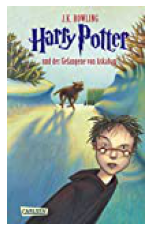

Такие рекомендации


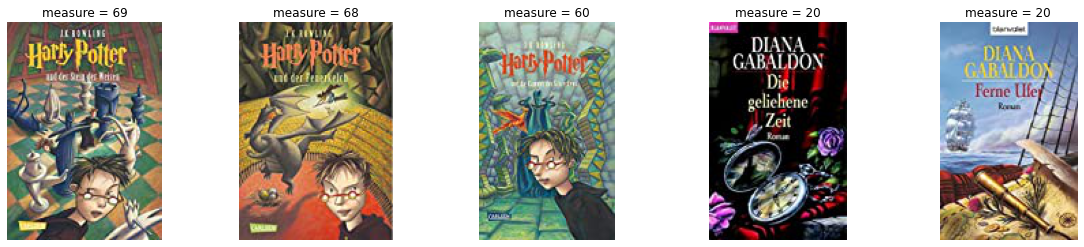

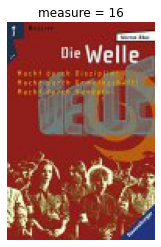

In [ ]:
cooc_rec.get_rec(10428)

## *Content-based*

In [ ]:
class Content_Based():
    def __init__(self, interactions):
        self.interactions = interactions
        self.content_dict = {}
        for i, j in enumerate(interactions["picture_url"]):
            self.content_dict[i] = j
        self.inversed_dict = {v: k for k, v in self.content_dict.items()}

        
    def avg_feature_vector(self, words, model, num_features, index2word_set):
        feature_vec = np.zeros((num_features, ), dtype='float32')
        n_words = 0
        for word in words:
            if word in index2word_set:
                n_words += 1
                feature_vec = np.add(feature_vec, model.wv[word])
        if (n_words > 0):
            feature_vec = feature_vec / n_words
        return feature_vec

    def get_items_representation(self):
        #учтем только автора и название книги, поскольку издательство не отображает интересов читателя
        self.text = self.interactions['BookAuthor'] + ' ' + self.interactions['BookTitle']
        item_description = [gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", i.lower())) 
                            for i in self.text.unique()]
        #build vocabulary and train model
        self.model = gensim.models.Word2Vec(
                item_description,
                size=200,
                window=10,
                min_count=1,
                workers=10,
                iter=100)
        self.index2word_set = set(self.model.wv.index2word)
        self.items_embs = np.zeros((len(item_description), 200))
        for i in range(self.items_embs.shape[0]):
            self.items_embs[i] = self.avg_feature_vector(item_description[i], self.model, 200, self.index2word_set)
        
        
    def get_rec_I2I(self, i):
        i = self.interactions[ self.interactions['product_id']==i].index[0]
        metrics = cosine_similarity([self.items_embs[i]], self.items_embs)

        books = np.argsort(metrics)[0][::-1][1:11]
        self.book = []
        for j in books:           
            self.book.append(self.interactions[self.interactions['picture_url'] == self.content_dict[j]]['BookTitle'].unique())
        k = 1
        print('Топ книг:')
        for j in range(len(self.book)):
            print(k , ' ' , self.book[j])
            k+=1

        print(u"Для такой")
        rec_imaging([i], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])

        

    def get_rec_U2I(self, i):
        ui = self.interactions[self.interactions["vid"] == i]    
        self.textUser = ui['BookAuthor'] + ' ' + ui['BookTitle']
        user_vector = " ".join(self.textUser)
        user_processed = gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", user_vector.lower()))
        user_emb = self.avg_feature_vector(user_processed, self.model, 200, self.index2word_set)
        metrics = cosine_similarity([user_emb], self.items_embs)

        books = np.argsort(metrics)[0][::-1][1:11]
        self.book = []
        for j in books:           
            self.book.append(self.interactions[self.interactions['picture_url'] == self.content_dict[j]]['BookTitle'].unique())
        k = 1
        print('Топ книг:')
        for j in range(len(self.book)):
            print(k , ' ' , self.book[j])
            k+=1 

        print(u"Для пользователя, который взаимодействовал с такими книгами")
        rec_imaging(np.unique([self.inversed_dict[i] for i in ui["picture_url"]]), self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])

In [ ]:
CB = Content_Based(interactions)
CB.get_items_representation()

Топ книг:
1   ['Die PÃ?Â¤pstin.']
2   ['Harry Potter und die Kammer des Schreckens']
3   ['Harry Potter und die Kammer des Schreckens']
4   ['Das Lacheln der Fortuna: Historischer Roman']
5   ['Das Blut der KÃ?Â¶nige. Roman.']
6   ['Interview with the Vampire']
7   ['Dead Ringer (Scottoline, Lisa)']
8   ['Harry Potter und die Kammer des Schreckens']
9   ['Die PÃ?Â¤pstin.']
10   ['Die Unertragliche Leichtigkeit des Seins...The Unbearable Lightness of Being']
Для такой


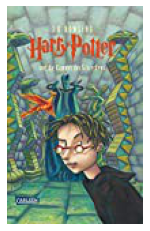

Такие рекомендации


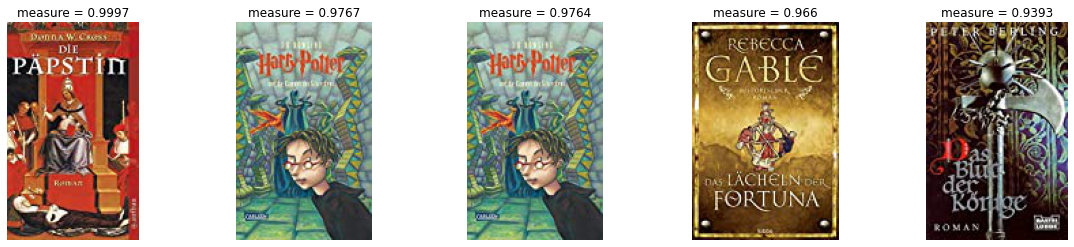

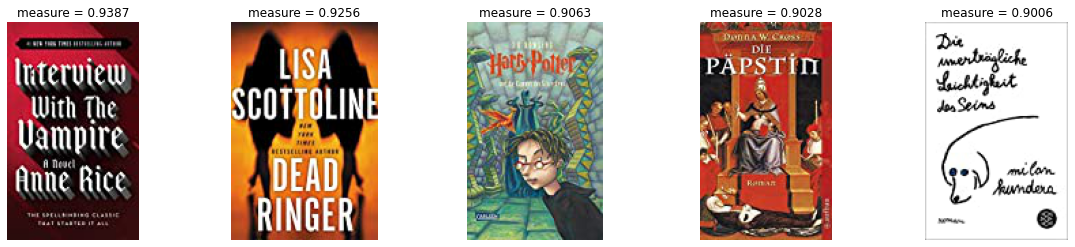

In [ ]:
CB.get_rec_I2I(10427)

Топ книг:
1   ['Die Jury. Roman.']
2   ['Die Jury. Roman.']
3   ['Die Jury. Roman.']
4   ['Harry Potter und der Stein der Weisen']
5   ['Jack &amp; Jill (Alex Cross Novels)']
6   ['Harry Potter und die Kammer des Schreckens']
7   ['Hannibal']
8   ['Cat &amp; Mouse (Alex Cross Novels)']
9   ['Angels &amp; Demons']
10   ['The Brethren']
Для пользователя, который взаимодействовал с такими книгами


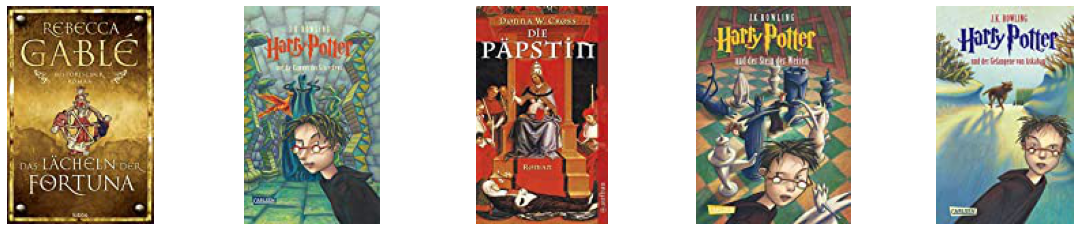

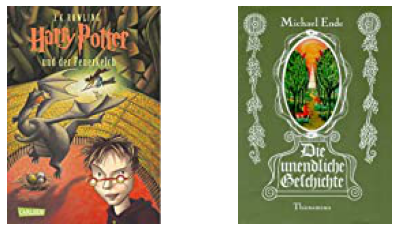

Такие рекомендации


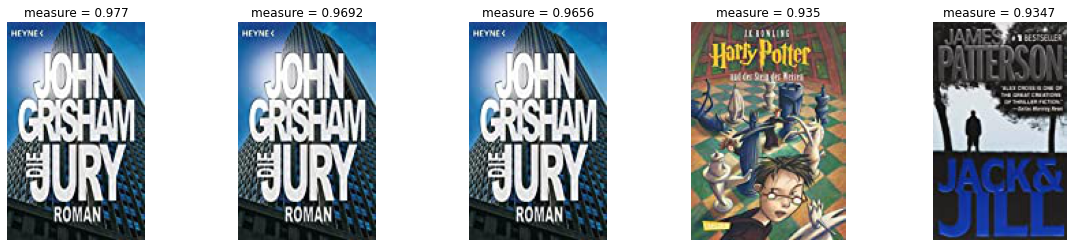

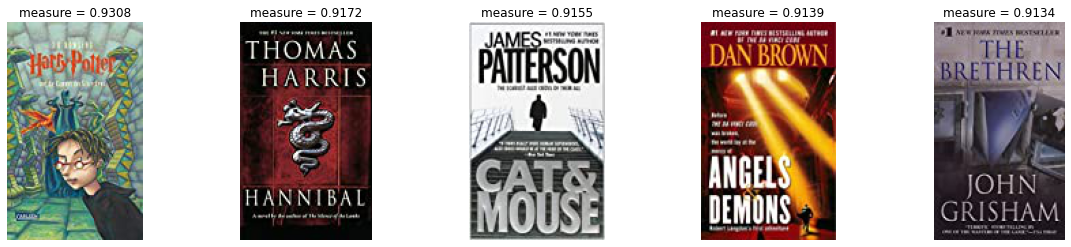

In [ ]:
CB.get_rec_U2I(2608)

In [ ]:
f = lambda x: 'Little Prince' in x
interactions[interactions['BookTitle'].apply(f)].head()

UserID        ISBN  BookRating_x  ...  Country  product_id   vid
21596  125519  0156465116  10            ...  usa      1226        4939
21597  100459  0156465116  8             ...  usa      1226        3970
21598  245410  0156465116  8             ...  usa      1226        9636
21599  140132  0156465116  7             ...  usa      1226        5554
56231  39773   0397306938  9             ...  usa      3579        1588

[5 rows x 15 columns]

## *Коллаборативная фильтрация*

In [ ]:
class Colloborative():
    def __init__(self, interactions):
        self.content_dict = {}
        for i, j in interactions[["product_id", "picture_url"]].drop_duplicates().values:
            self.content_dict[int(i)] = j
        self.csr_rates = coo_matrix((interactions["BookRating_x"], (interactions["vid"], interactions["product_id"])), 
                    shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))
        self.interactions = interactions

    def user_based(self, idx):
        # считаем косинус между пользователем idx и всеми пользователями
        user_rates = self.csr_rates.getrow(idx).toarray()[0]
        watched_items = np.where(user_rates != 0)[0]
        metrics = cosine_similarity([user_rates], self.csr_rates)[0]
        (x,y,z) = scipy.sparse.find(self.csr_rates)
        countings = numpy.bincount(x)
        sums = numpy.bincount(x,weights = z)
        # средние оценки пользователей
        averages = sums/countings
        # разность оценок пользователей и их средних оценок
        k=0
        arr = self.csr_rates.toarray()
        for i in arr:
          ai = i
          ai[ai > 0] = ai[ai > 0] - averages[k]
          k += 1
        # домножаем эту разность на коэффициент похожести
        rates = metrics.reshape(-1, 1) * arr.copy()
        # чтобы не рекомендовать уже просмотренные - зануляем веса просмотренных и суммируем
        total_rate1 = (1 - user_rates.astype(bool)) * np.array(np.sum(rates, axis=0))
        #делим
        total_rate2 = total_rate1 / np.array(np.abs(metrics).sum())
        #добавляем среднюю оценку данного пользователя
        total_rate3 = total_rate2 + averages[idx]
        watched = watched_items
        top_rat = np.sort(total_rate3)[::-1][:10]
        top_rat[top_rat > 10] = 10
        # печатаем рекомендации
        self.get_rec(watched_items, np.argsort(total_rate3)[::-1][:10],
                    top_rat)

        
    def item_based(self, idx):
        # считаем косинус между товаром idx и всеми товарами
        item_rates = self.csr_rates.getcol(idx).toarray().reshape(1, -1)
        metrics = cosine_similarity(item_rates, self.csr_rates.T)[0]
        # домножаем оценки 
        (x,y,z) = scipy.sparse.find(self.csr_rates.T)
        countings = numpy.bincount(x)
        sums = numpy.bincount(x,weights = z)
        # средние оценки товаров
        averages = sums/countings 
        # разность оценок пользователей и средних оценок
        k=0
        arr = self.csr_rates.T.copy().toarray()
        for i in arr:
          ai = i
          ai[ai > 0] = ai[ai > 0] - averages[k]
          k += 1
        # домножаем разность на коэффициент похожести
        rates = metrics.reshape(-1, 1) * arr.copy()      
        total_rate1 = np.array(np.sum(rates, axis=1)).ravel()
        #делим
        total_rate2 = total_rate1 / np.array(np.abs(metrics).sum())
        #добавляем среднюю оценку этой книги
        total_rate3 = total_rate2 + averages[idx]
        watched = [idx]
        # печатаем рекомендации
        self.get_rec(watched, np.argsort(total_rate3)[::-1][:10],
                    np.sort(total_rate3)[::-1][:10])
    
    def get_rec(self, watched, recs, measure):

        books = recs
        self.book = []
        
        for j in range(len(books)):          
            self.book.append(self.interactions[(self.interactions['product_id'] == books[j])]['BookTitle'].unique())
        k = 1
        print('Топ книг:')
        for j in range(len(self.book)):
            print(k , ' ' , self.book[j])
            k+=1

        print(u"Для таких(ой) книг(и)")
        rec_imaging([i for i in watched], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging([i for i in recs], self.content_dict, measure)

In [ ]:
clb = Colloborative(interactions)

Топ книг:
1   ['Der Regenmacher.']
2   ['Ferne Ufer. Der 3. Band der groÃ?Â?en Highland- Saga.']
3   ['Die geliehene Zeit.']
4   ['The Da Vinci Code']
5   ['Die SÃ?Â¤ulen der Erde. Roman.']
6   ['The Pelican Brief']
7   ["One Flew Over the Cuckoo's Nest"]
8   ['Angels &amp; Demons']
9   ['Vittorio the Vampire: New Tales of the Vampires']
10   ['The Stand: Complete and Uncut']
Для таких(ой) книг(и)


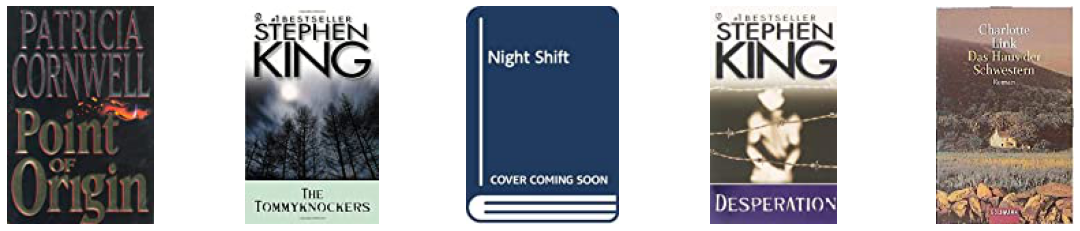

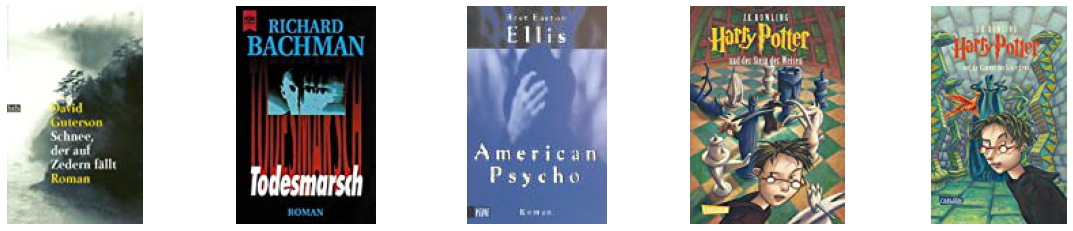

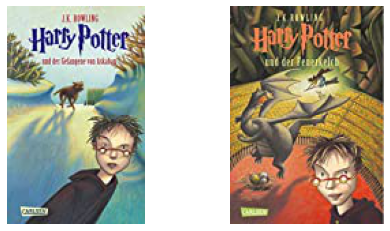

Такие рекомендации


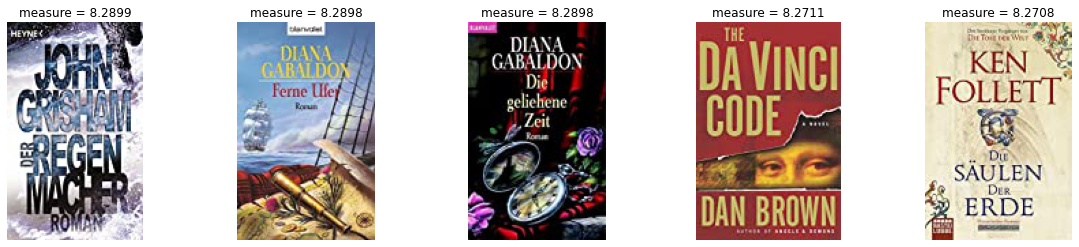

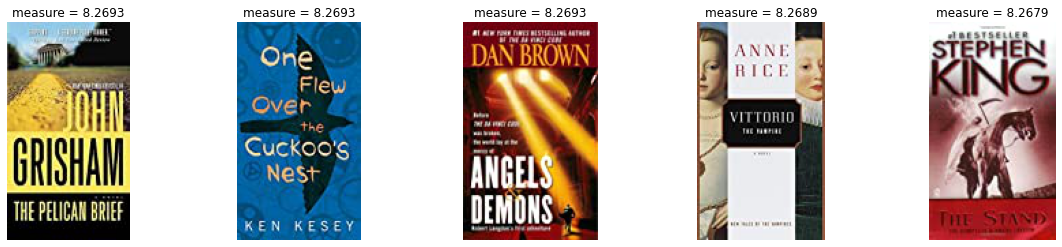

In [ ]:
clb.user_based(5329)

Топ книг:
1   ['Harry Potter and the Chamber of Secrets (Book 2)']
2   ['Harry Potter and the Prisoner of Azkaban (Book 3)']
3   ['Good in Bed']
4   ['Confessions of a Shopaholic (Summer Display Opportunity)']
5   ['Into the Wild']
6   ['Divine Secrets of the Ya-Ya Sisterhood: A Novel']
7   ['Interview with the Vampire']
8   ['Hot Six : A Stephanie Plum Novel (A Stephanie Plum Novel)']
9   ['The Tommyknockers']
10   ['Balzac and the Little Chinese Seamstress : A Novel']
Для таких(ой) книг(и)


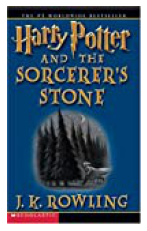

Такие рекомендации


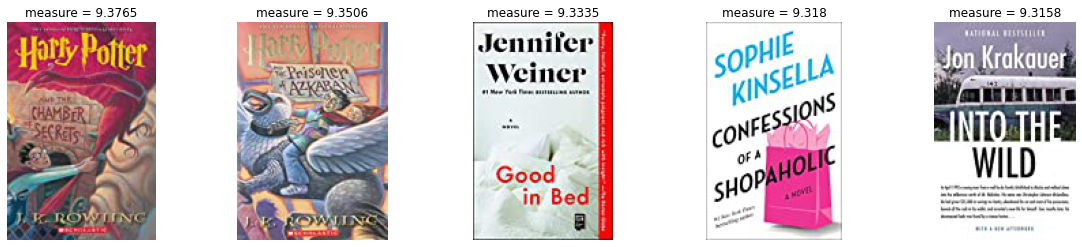

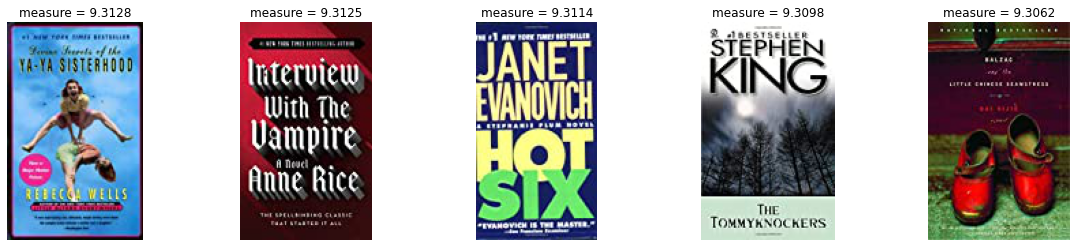

In [ ]:
clb.item_based(4169)

## *Матричная Факторизация*

In [ ]:
class MatrixFactorization():
  def __init__(self, interactions=interactions):
    self.content_dict = {}
    self.interactions = interactions
    for i, j in interactions[["product_id", "picture_url"]].drop_duplicates().values:
            self.content_dict[i] = j
    self.csr_rates = coo_matrix((interactions["BookRating_x"], (interactions["vid"], interactions["product_id"])), 
                    shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))

  def LightFM(self):
    self.model = LightFM(loss='warp', no_components=400, learning_rate=0.03, learning_schedule="adadelta")
    self.model.fit(self.csr_rates, epochs=5, num_threads=40, verbose=True)
    self.user_feature_bias, self.user_feature_embeddings = self.model.get_user_representations()
    self.item_feature_bias, self.items_embs = self.model.get_item_representations()

  def get_rec_I2I(self, i):
        metrics = cosine_similarity([self.items_embs[i]], self.items_embs)
        books = np.argsort(-metrics)[0][1:11]
        self.book = []       
        for j in range(len(books)):          
            self.book.append(self.interactions[(self.interactions['product_id'] == books[j])]['BookTitle'].unique())
        k = 1
        print('Топ книг:')
        for j in range(len(self.book)):
            print(k , ' ' , self.book[j])
            k+=1          
        print(u"Для товара")
        rec_imaging([i], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(-metrics)[0][1:11], self.content_dict, -np.round(np.sort(-metrics)[0][1:11], 4))

  def get_rec_U2I(self, i):
        metrics = cosine_similarity([self.user_feature_embeddings[i]], self.user_feature_embeddings)
        books = np.argsort(-metrics)[0][1:11]
        self.book = []       
        for j in range(len(books)):          
            self.book.append(self.interactions[(self.interactions['product_id'] == books[j])]['BookTitle'].unique())
        k = 1
        print('Топ книг:')
        for j in range(len(self.book)):
            print(k , ' ' , self.book[j])
            k+=1           
        print(u"Для юзера ", i)
        rec_imaging(np.unique(self.interactions[self.interactions['vid']==i]['product_id']), self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(-metrics)[0][1:11], self.content_dict, -np.round(np.sort(-metrics)[0][1:11], 4))


In [ ]:
simple_svd = MatrixFactorization(interactions)
simple_svd.LightFM()

Epoch: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Топ книг:
1   ['Harry Potter und der Gefangene von Azkaban']
2   ['Harry Potter Und Der Feuerkelch']
3   ['Harry Potter und die Kammer des Schreckens']
4   ['Ferne Ufer. Der 3. Band der groÃ?Â?en Highland- Saga.']
5   ['Die geliehene Zeit.']
6   ['Nordermoor']
7   ['Der Kleine Hobbit']
8   ['Todesmarsch. Roman.']
9   ['Dunkle Kammern.']
10   ['Die Zauberfrau.']
Для такой книги


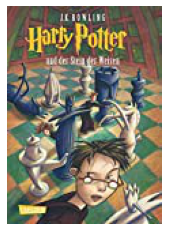

Такие рекомендации


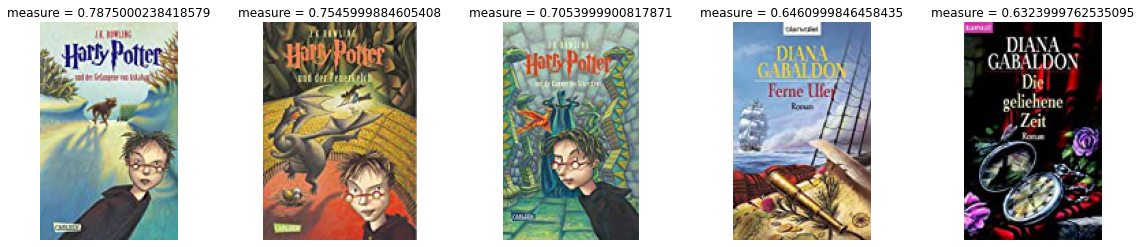

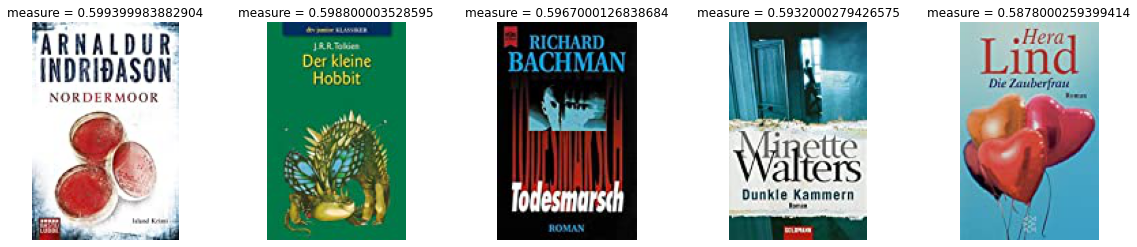

In [ ]:
simple_svd.get_rec_I2I(10426)

Топ книг:
1   ['Great Expectations (English Library)']
2   ['The Face on the Milk Carton']
3   ["The Professor's House (Vintage Classic)"]
4   ['The Harbor']
5   ['Dracula (Wordsworth Classics)']
6   ['Bodily Harm']
7   ["Ender's Shadow (Ender Wiggins Saga (Hardcover))"]
8   ['A Kiss of Shadows (Meredith Gentry Novels (Paperback))']
9   ['Raney']
10   ['Princess in the Spotlight (The Princess Diaries, Vol. 2)']
Для юзера  111


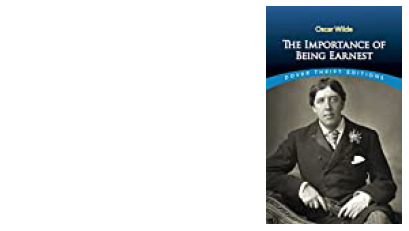

Такие рекомендации


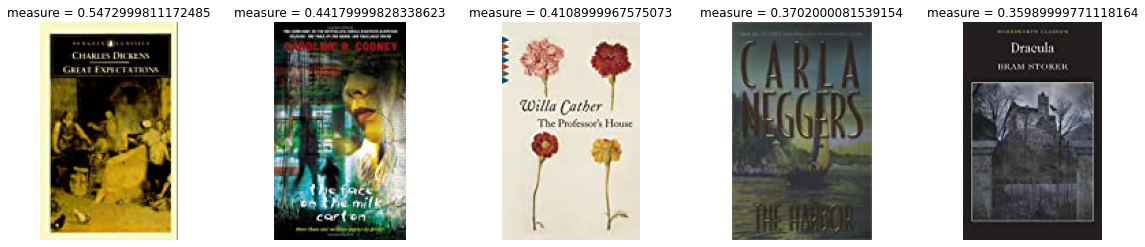

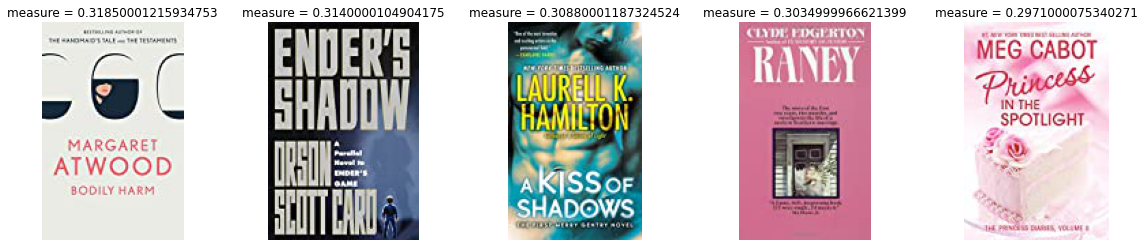

In [ ]:
simple_svd.get_rec_U2I(111)

# Выводы

1. При кластеризации и совстречаемости не учитываются особенности каждого юзера, то есть рекомендации неперсонализованные.
2. В content-based для юзера создается вектор предпочтений в пространстве книг (они имеют признаковое описание). Рекомендуются книги, близкие к этому вектору. Каждому пользователю – свои рекомендации. Чем больше данных - тем точнее рекомендация. 
3. В коллаборативной фильтрации мы использувем матрицу оценок (юзер-книга).В user-based мы ищем похожих на нашего юзера и усредняем их оценки, в item-based все наоборот, мы смотрим на "схожесть" книг, считая, что похожие книги нравятся похожим юзерам(матрица оценок транспонируется).
Т.к. о новых юзерах у нас нет информации, хорошую рекомендацию не реализовать.
Из примеров видно, что item-based работает несколько лучше (на примерах книг тяжело определить схожесть, т.к. знакомых книг, к сожалению, небольшое количество).
4. В матричной факторизации идет разделение матрицы оценок на две - матрицу юзеров и матрицу книг с соответствующими признаками. Происходит так называемое уменьшение размерности (скрытые факторы имеют меньшее пространство измерений).  Данный метод позволяет рекомендовать менее известные книги, но более подходящие для юзера. Именно "скрытые" и является недостатком, посколько происходит снижение интерпретируемости.

Поэтому, учитывая плюсы и минусы каждого метода, можно попробовать их объединить)